<span style='font-family:"Times New Roman"'><font size="3">ml-zoomcap DataTalks : projet 1
</font></span>
<br />
<br />
<br />
<br />
**</span><span style='font-family:"Times New Roman"'><div align="center"><font size="6"> Classification algorithme on Maternal Health Risk during pregnancy.
</font></div></span>**
<br /><br />
<span style='font-family:"Times New Roman"'><font size="5"><div align="right">*Marie Vallauri*</div></font></span>
<br />
_____
<span style='color:blue'></span>
<br />
<br />

In [1]:
# import des librairies

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix,
                             accuracy_score, roc_auc_score,
                             mutual_info_score, roc_curve, classification_report)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import pickle

# dataset présentation

Data has been collected from different hospitals, community clinics, maternal health cares through the IoT based risk monitoring system.

    Age: Age in years when a woman is pregnant.
    SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
    DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
    BS: Blood glucose levels is in terms of a molar concentration, mmol/L.
    HeartRate: A normal resting heart rate in beats per minute.
    Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.


In [2]:
#import du dataset

df = pd.read_csv("Maternal Health Risk Data Set.csv")

In [3]:
#forme du dataset

df.shape

(1014, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [5]:
df.RiskLevel.unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [6]:
df.RiskLevel.describe()

count         1014
unique           3
top       low risk
freq           406
Name: RiskLevel, dtype: object

In [7]:
df.RiskLevel.value_counts()

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64

## analyse descriptive

In [8]:
# info diverses

df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [9]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


As we need a binary target, I decide here to predict the Hight level risks state and group low and mid risks

In [10]:
df['HighRisk'] = (df.RiskLevel == 'high risk')

In [11]:
del df['RiskLevel']
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,HighRisk
0,25,130,80,15.0,98.0,86,True
1,35,140,90,13.0,98.0,70,True
2,29,90,70,8.0,100.0,80,True
3,30,140,85,7.0,98.0,70,True
4,35,120,60,6.1,98.0,76,False


## analyse des variables

C:\Users\laara\anaconda3\envs\ml-zoomcamp\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


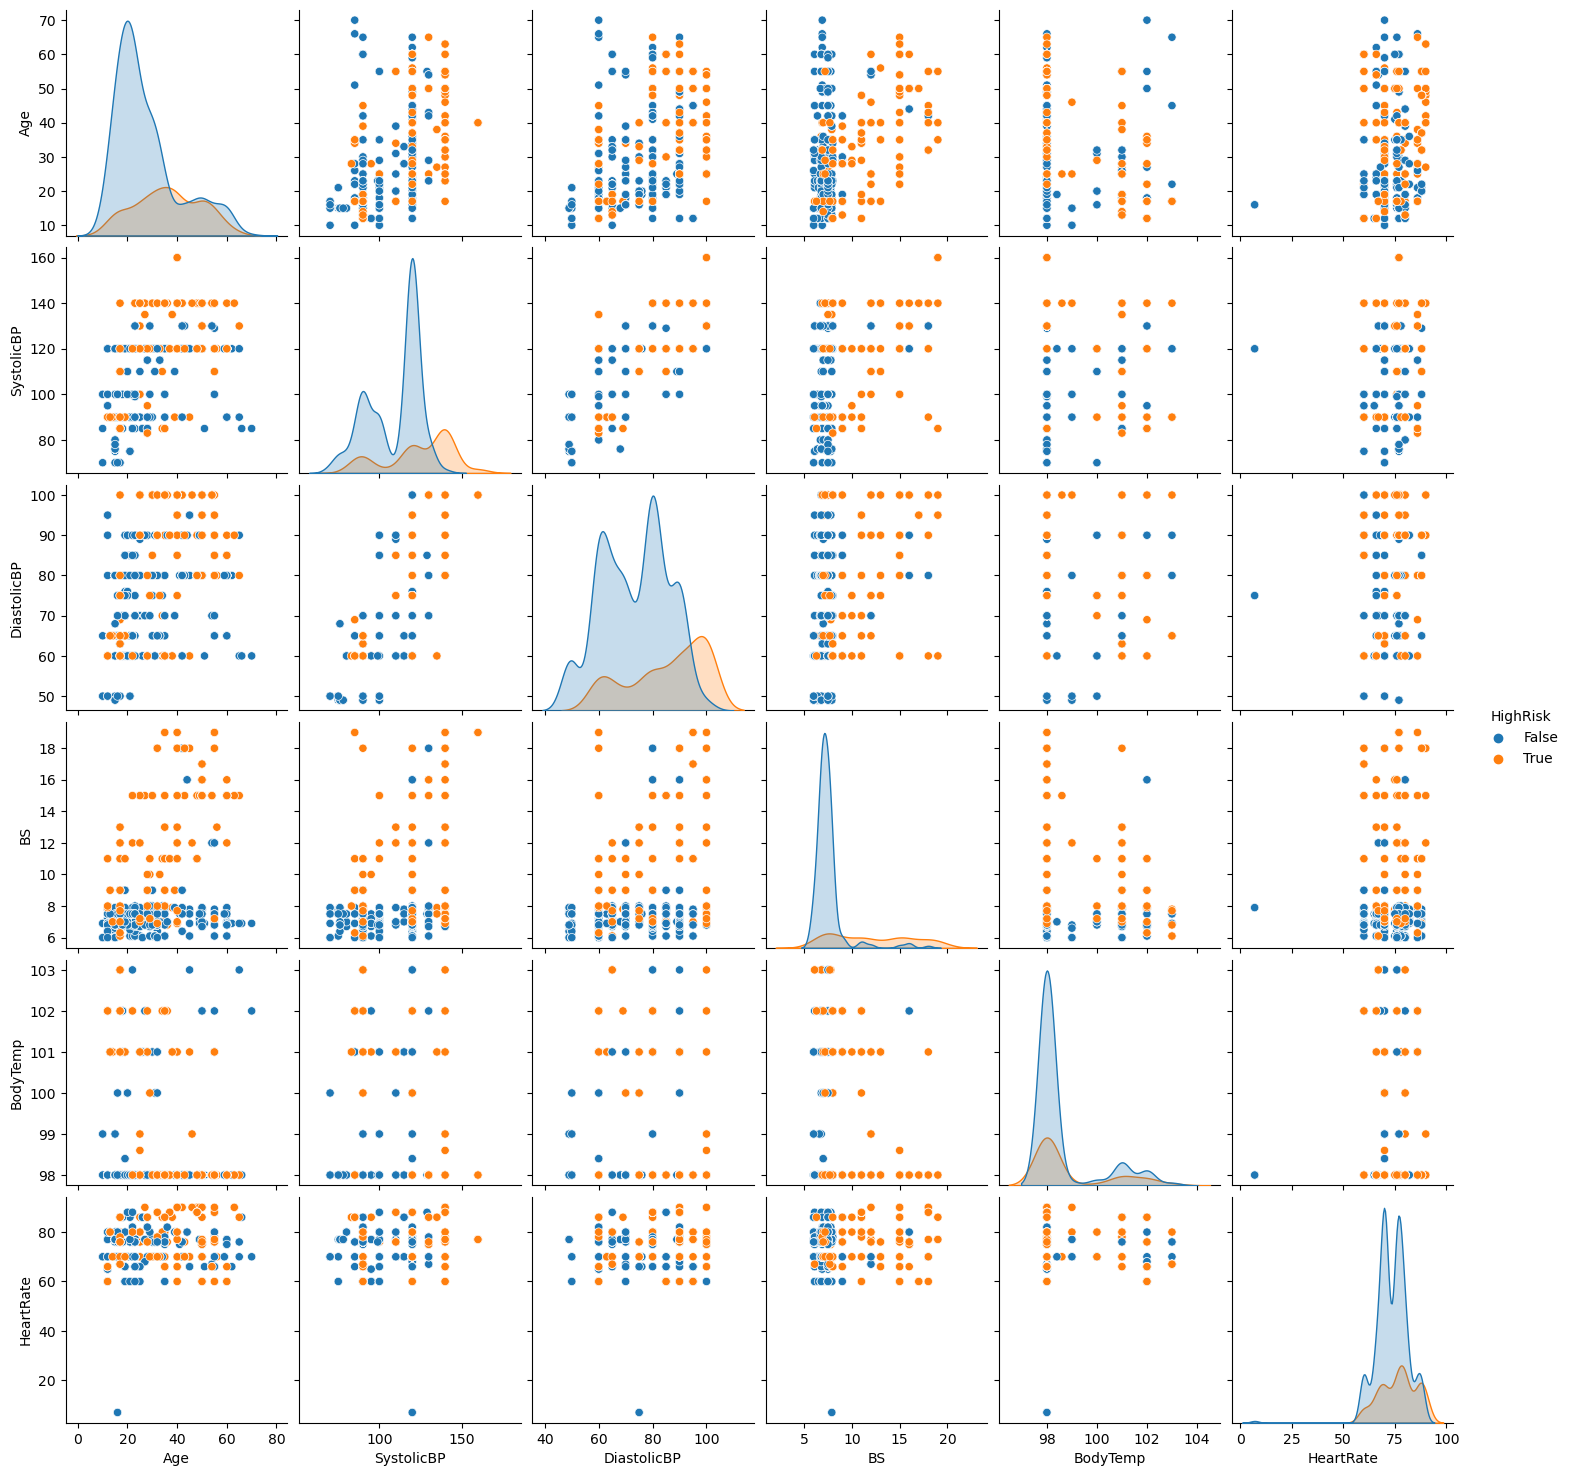

In [12]:
# représentation graphique par présence de risk

sns.pairplot(df,hue = "HighRisk" )

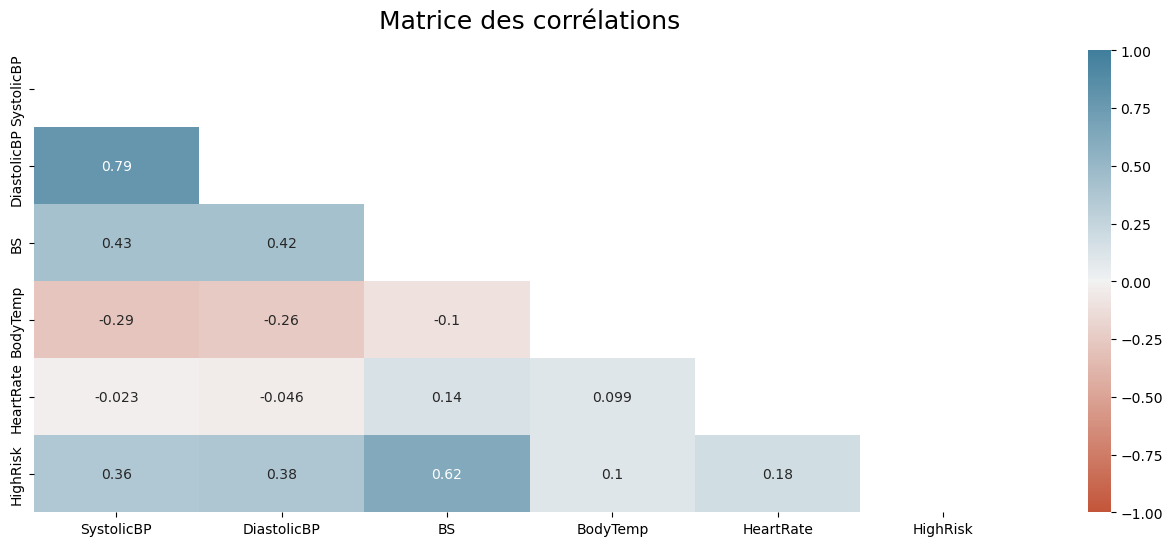

In [13]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

corr_df = df[df.columns[1:]].corr(method='pearson')

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr_df, dtype=bool))
heatmap = sns.heatmap(corr_df, mask=mask, vmin=-1, vmax=1, annot=True, cmap=cmap)
heatmap.set_title('Matrice des corrélations', fontdict={'fontsize':18}, pad=16);

<span style='font-family:"Times New Roman"'><font size="4">Due to high correlation between Diastolic and SystolicBP, I choose concerve only one of them, the less correlated one. <br /></font></span><br />

In [14]:
del df['DiastolicBP']

<span style='font-family:"Times New Roman"'><font size="4">------------------</font></span><br /><br />

# dataset preparation<br />


In [15]:
labels = df.drop(columns=['HighRisk']).columns

In [16]:
labels

Index(['Age', 'SystolicBP', 'BS', 'BodyTemp', 'HeartRate'], dtype='object')

In [17]:
X = df.drop(columns=['HighRisk'])
y = df['HighRisk']

In [18]:
# take y to stratified to obtain same structure in all dataset

X_full_train, X_test, y_full_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1, shuffle = True, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.25, random_state = 1, shuffle = True, stratify = y)

# regression logistique<br />


In [19]:
# avec sklearn
log_reg = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
log_reg = log_reg.fit(X_train, y_train)

In [20]:
# sklearn
pred_val = log_reg.predict(X_val)

In [21]:
round(accuracy_score(y_val, pred_val), 5)

0.81496

In [22]:
round(roc_auc_score(y_val, pred_val), 5)

0.71505

In [23]:
print(np.unique(pred_val, return_counts=True))

(array([False,  True]), array([207,  47], dtype=int64))


In [24]:
print(confusion_matrix(y_val, pred_val))

[[173  13]
 [ 34  34]]


In [25]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

       False       0.84      0.93      0.88       186
        True       0.72      0.50      0.59        68

    accuracy                           0.81       254
   macro avg       0.78      0.72      0.74       254
weighted avg       0.81      0.81      0.80       254



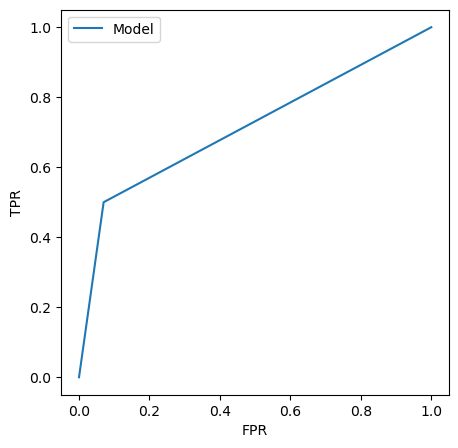

In [26]:
fpr, tpr, thresholds = roc_curve(y_val, pred_val)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [27]:
X_train.columns

Index(['Age', 'SystolicBP', 'BS', 'BodyTemp', 'HeartRate'], dtype='object')

In [28]:
X_train.values

array([[ 55.  , 110.  ,   6.9 ,  98.  ,  88.  ],
       [ 23.  , 130.  ,   7.01,  98.  ,  78.  ],
       [ 25.  , 140.  ,   7.9 ,  98.  ,  80.  ],
       ...,
       [ 35.  , 120.  ,   6.1 ,  98.  ,  76.  ],
       [ 23.  , 140.  ,   6.8 ,  98.  ,  70.  ],
       [ 50.  , 130.  ,  15.  ,  98.  ,  86.  ]])

In [29]:
X_train.shape

(760, 5)

In [30]:
y_train.shape

(760,)

In [31]:
df_train = pd.DataFrame(X_train, columns = labels)
df_train = df_train.join(pd.DataFrame(y_train))
df_train.head(2)

,Age,SystolicBP,BS,BodyTemp,HeartRate,HighRisk
254,55,110,6.90,98.0,88,False
852,23,130,7.01,98.0,78,False


In [32]:
df_val = pd.DataFrame(X_val, columns = labels)
df_val = df_val.join(pd.DataFrame(y_val))

In [33]:
num = ['Age', 'SystolicBP', 'BS', 'BodyTemp', 'HeartRate']
roc_value = []
col = []
X_train = df_train[num]
for feature in X_train.columns :
    model = LogisticRegression()
    model.fit(X_train[feature].to_frame(), y_train)
    
    y_score = model.predict_proba(X_train[feature].to_frame())
    
    roc_value.append(roc_auc_score(y_train, y_score[:, 1]))
    col.append(feature)
                     
pd.DataFrame(index = col, data = roc_value, columns = ['roc_value']).sort_values('roc_value', axis=0, ascending=False)

,roc_value
BS,0.873581
SystolicBP,0.747267
Age,0.731203
HeartRate,0.630814
BodyTemp,0.464549


 ## I use the feature elimination technique to find the least useful feature

In [34]:
numerical = ['Age', 'SystolicBP', 'BS', 'BodyTemp']
X_train = df_train[numerical].values

# entraînement aux même paramètres que précédemment, donc def model ne change pas
log_reg.fit(X_train, y_train)

# traitement du val
X_val = df_val[numerical].values

# observation des résultats
y_pred = log_reg.predict(X_val)
acc_score = round(accuracy_score(y_val, y_pred), 5)
auc_score = round(roc_auc_score(y_val, y_pred), 5)
print(acc_score, auc_score)

0.82283 0.70644


In [35]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

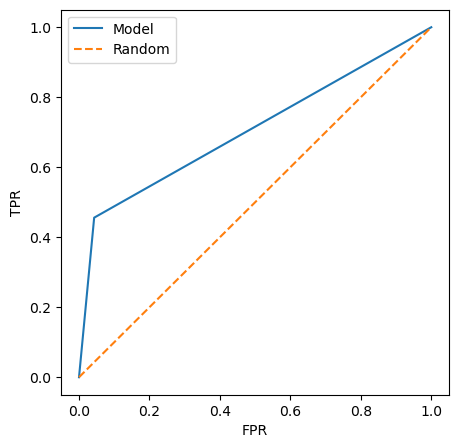

In [36]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [37]:
numerical = ['Age', 'SystolicBP', 'BS', 'HeartRate']
X_train = df_train[numerical].values

# entraînement aux même paramètres que précédemment, donc def model ne change pas
log_reg.fit(X_train, y_train)

# traitement du val
X_val = df_val[numerical].values

# observation des résultats
y_pred = log_reg.predict(X_val)
acc_score = round(accuracy_score(y_val, y_pred), 5)
auc_score = round(roc_auc_score(y_val, y_pred), 5)
print(acc_score, auc_score)

0.81102 0.71237


In [38]:
numerical = ['Age', 'SystolicBP', 'BodyTemp', 'HeartRate']
X_train = df_train[numerical].values

# entraînement aux même paramètres que précédemment, donc def model ne change pas
log_reg.fit(X_train, y_train)

# traitement du val
X_val = df_val[numerical].values

# observation des résultats
y_pred = log_reg.predict(X_val)
acc_score = round(accuracy_score(y_val, y_pred), 5)
auc_score = round(roc_auc_score(y_val, y_pred), 5)
print(acc_score, auc_score)

0.77559 0.65552


In [39]:
numerical = ['Age', 'BS', 'BodyTemp', 'HeartRate']
X_train = df_train[numerical].values

# entraînement aux même paramètres que précédemment, donc def model ne change pas
log_reg.fit(X_train, y_train)

# traitement du val
X_val = df_val[numerical].values

# observation des résultats
y_pred = log_reg.predict(X_val)
acc_score = round(accuracy_score(y_val, y_pred), 5)
auc_score = round(roc_auc_score(y_val, y_pred), 5)
print(acc_score, auc_score)

0.8189 0.72707


In [40]:
numerical = ['SystolicBP', 'BS', 'BodyTemp', 'HeartRate']
X_train = df_train[numerical].values

# entraînement aux même paramètres que précédemment, donc def model ne change pas
log_reg.fit(X_train, y_train)

# traitement du val
X_val = df_val[numerical].values

# observation des résultats
y_pred = log_reg.predict(X_val)
acc_score = round(accuracy_score(y_val, y_pred), 5)
auc_score = round(roc_auc_score(y_val, y_pred), 5)
print(acc_score, auc_score)

0.81102 0.71237


## le meilleur modèle de regression logistique retient en features 'Age', 'BS', 'BodyTemp', 'HeartRate' mais rejette 'BodyTemp'

In [41]:
numerical = ['Age', 'BS', 'BodyTemp', 'HeartRate']
X_train = df_train[numerical].values

# entraînement aux même paramètres que précédemment, donc def model ne change pas
log_reg.fit(X_train, y_train)

# traitement du val
X_val = df_val[numerical].values

# observation des résultats
y_pred_rl = log_reg.predict(X_val)
acc_score = round(accuracy_score(y_val, y_pred_rl), 5)
auc_score = round(roc_auc_score(y_val, y_pred_rl), 5)
print(acc_score, auc_score)

0.8189 0.72707


# classification par decision tree

In [42]:
numerical = labels
X_train = df_train[numerical].values
X_val = df_val[numerical].values

In [43]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [44]:
pred_train = dt.predict(X_train)
auc = round(roc_auc_score(y_train, pred_train), 5)
print('train:', auc)

pred_val = dt.predict(X_val)
auc = round(roc_auc_score(y_val, pred_val), 5)
print('val:', auc)

train: 0.9048
val: 0.81515


## Decision tree learning algorithm

### tuning

In [45]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.730
   2 -> 0.840
   3 -> 0.907
   4 -> 0.947
   5 -> 0.954
   6 -> 0.942
  10 -> 0.932
  15 -> 0.942
  20 -> 0.942
None -> 0.936


In [46]:
scores = []

for depth in [4, 5, 6, 10 , None]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [47]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [48]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                            
max_depth           NaN   4.0    5.0    6.0    10.0
min_samples_leaf                                   
1                 0.953  0.947  0.954  0.942  0.945
5                 0.947  0.936  0.946  0.946  0.941
10                0.937  0.932  0.942  0.936  0.937
15                0.932  0.932  0.923  0.928  0.931
20                0.914  0.926  0.911  0.914  0.914
100               0.831  0.831  0.831  0.831  0.831
200               0.770  0.770  0.770  0.770  0.770
500               0.500  0.500  0.500  0.500  0.500

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

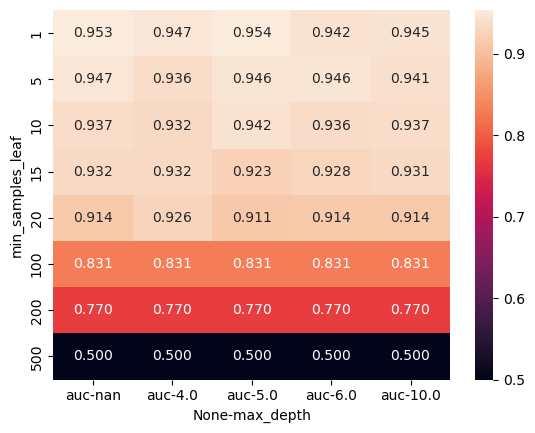

In [49]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

## choix du modèle dt

In [50]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

In [51]:
y_pred_dt = dt.predict(X_val)
auc = roc_auc_score(y_val, y_pred_dt)
round(auc, 5)

0.84401

# Random Forest classifier

In [52]:
scores = []

for n in range(1, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [53]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

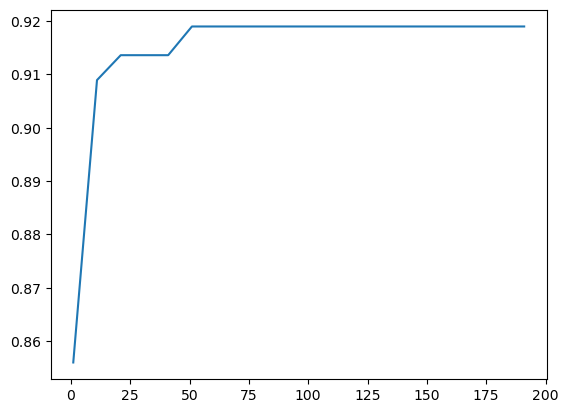

In [54]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [55]:
scores = []

for n in range(1, 26, 1):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [56]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

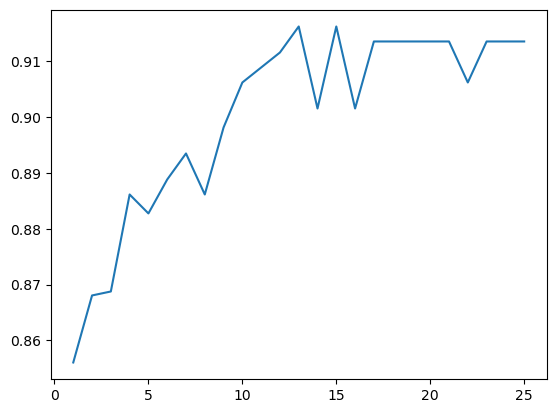

In [57]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [58]:
df_scores.iloc[10:18, :]

,n_estimators,auc
10,11,0.908918
11,12,0.911607
12,13,0.916271
13,14,0.901565
14,15,0.916271
15,16,0.901565
16,17,0.913583
17,18,0.913583


<span style='font-family:"Times New Roman"'><font size="5">Evaluation du modèle de segmentation par random forest <br /></font></span>

In [59]:
rf = RandomForestClassifier(n_estimators=12, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)
round(roc_auc_score(y_train, y_pred), 5)

0.96895

In [60]:
y_pred_rf = rf.predict(X_val)
auc = roc_auc_score(y_val, y_pred_rf)
round(auc, 5)

0.91161

In [61]:
# matrice de confusion

cf_matrix = confusion_matrix(y_val, y_pred_rf)
print(cf_matrix)
print('Test accuracy = ', accuracy_score(y_val, y_pred_rf))

[[175  11]
 [  8  60]]
Test accuracy =  0.9251968503937008


In [62]:
# indicateurs
print(classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

       False       0.96      0.94      0.95       186
        True       0.85      0.88      0.86        68

    accuracy                           0.93       254
   macro avg       0.90      0.91      0.91       254
weighted avg       0.93      0.93      0.93       254



# comparaison des modèles entre eux

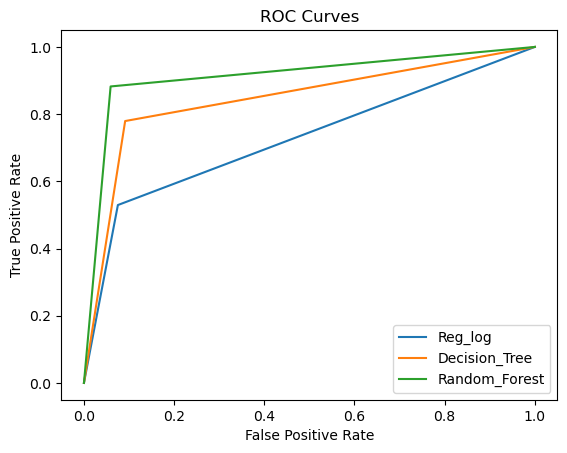

In [63]:
from sklearn.metrics import roc_curve
actual = y_val
predicted_rl = y_pred_rl
predicted_dt = y_pred_dt
predicted_rf = y_pred_rf

fpr, tpr, thresholds = roc_curve(actual, predicted_rl)
plt.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(actual, predicted_dt)
plt.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(actual, predicted_rf)
plt.plot(fpr, tpr)

plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Reg_log", "Decision_Tree", "Random_Forest"])
plt.show()

# Mise en forme du modèle retenu et test sur un nouveau dataset

In [64]:
model = RandomForestClassifier(n_estimators=12, random_state=1)
model.fit(X_full_train, y_full_train)

y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
round(auc, 5)

0.89156

# AUTOMATISATION

In [65]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)